In [1]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from tqdm import tqdm

from torch.nn import functional as F
from collections import OrderedDict
import math
device = "cuda"

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  1
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# load model and data

In [3]:
chip="H3K27ac"
X_Ctrl = np.load("./Datasets/Ctrl_"+chip+".npy",allow_pickle=True)
X_VPA = np.load("./Datasets/VPA_"+chip+".npy",allow_pickle=True)
y_Ctrl = torch.zeros(len(X_Ctrl), dtype=torch.int64)
y_VPA = torch.ones(len(X_VPA), dtype=torch.int64)
X = np.concatenate((X_Ctrl, X_VPA), axis = 0)
y = torch.cat((y_Ctrl, y_VPA), 0)

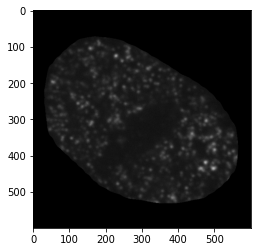

In [11]:
plt.imshow(X[1])

# define class function

In [4]:
# 定义钩子函数，获取指定层名称的特征
feature_activation = {} # 保存获取的输出
def get_activation(name):
    def hook(model, input, output):
        feature_activation[name] = output.detach()
    return hook

In [16]:
def predict(img,model,input_img,label):
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(input_img).unsqueeze(0).to(device)
    output = model(input_tensor)
    y = output.argmax(1).cpu().item()
    return y==label, y

def plot_feature(img,model,input_img,target_layer):
    for name, layer in model.named_modules():
        layer.register_forward_hook(get_activation(name))
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(input_img).unsqueeze(0).to(device)
    output = model(input_tensor)
    # plot each layer result
    for key in [target_layer]:
        bn = feature_activation[key].cpu()
        print(key," : ",bn.shape)
        s = int(input_img.shape[0]/bn.shape[2])
        n = math.ceil(math.sqrt(bn.shape[1]))
        plt.figure(figsize=(20,20))
        for i in range(bn.shape[1]):
            plt.subplot(n,n,i+1)
#                 plt.imshow(bn[0,i,:,:], cmap='gray')
            plt.imshow(bn[0,i], cmap='gray')
        plt.show()

In [32]:
# load model
homepath="/groups/4/gaa50089/acd13264yb/Epigenetic/Classification"
modelpath=homepath+"/Models/"
chip="H3K27ac"
resnet="Resnet10_max2avg"
weight=torch.load(modelpath+resnet+"_"+chip+".pkl")
print(modelpath+resnet+"_"+chip+".pkl")

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.resnet = models.resnet18(weights=True)
        self.resnet.maxpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.resnet.layer3 = nn.Sequential()
        self.resnet.layer4 = nn.Sequential()
        self.resnet.avgpool = nn.Sequential()
        self.resnet.fc = nn.Linear(128*75*75, 2)
        self.resnet.load_state_dict(weight)
    def forward(self, x):
        x = self.resnet(x)
        x = nn.Softmax(dim=1)(x)
        return x
        
model = ResNet().to(device)
model

/groups/4/gaa50089/acd13264yb/Epigenetic/Classification/Models/Resnet10_max2avg_H3K27ac.pkl


ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu)

In [35]:
for name, layer in model.named_modules():
        layer.register_forward_hook(get_activation(name))
         
img = X[1]
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to(device)
output = model(input_tensor)
print("Discrimination: ", output.argmax(1).cpu().item(), output.argmax(1).cpu().item()==y[1])

Discrimination:  0 tensor(True)


resnet.conv1  :  torch.Size([1, 64, 300, 300])


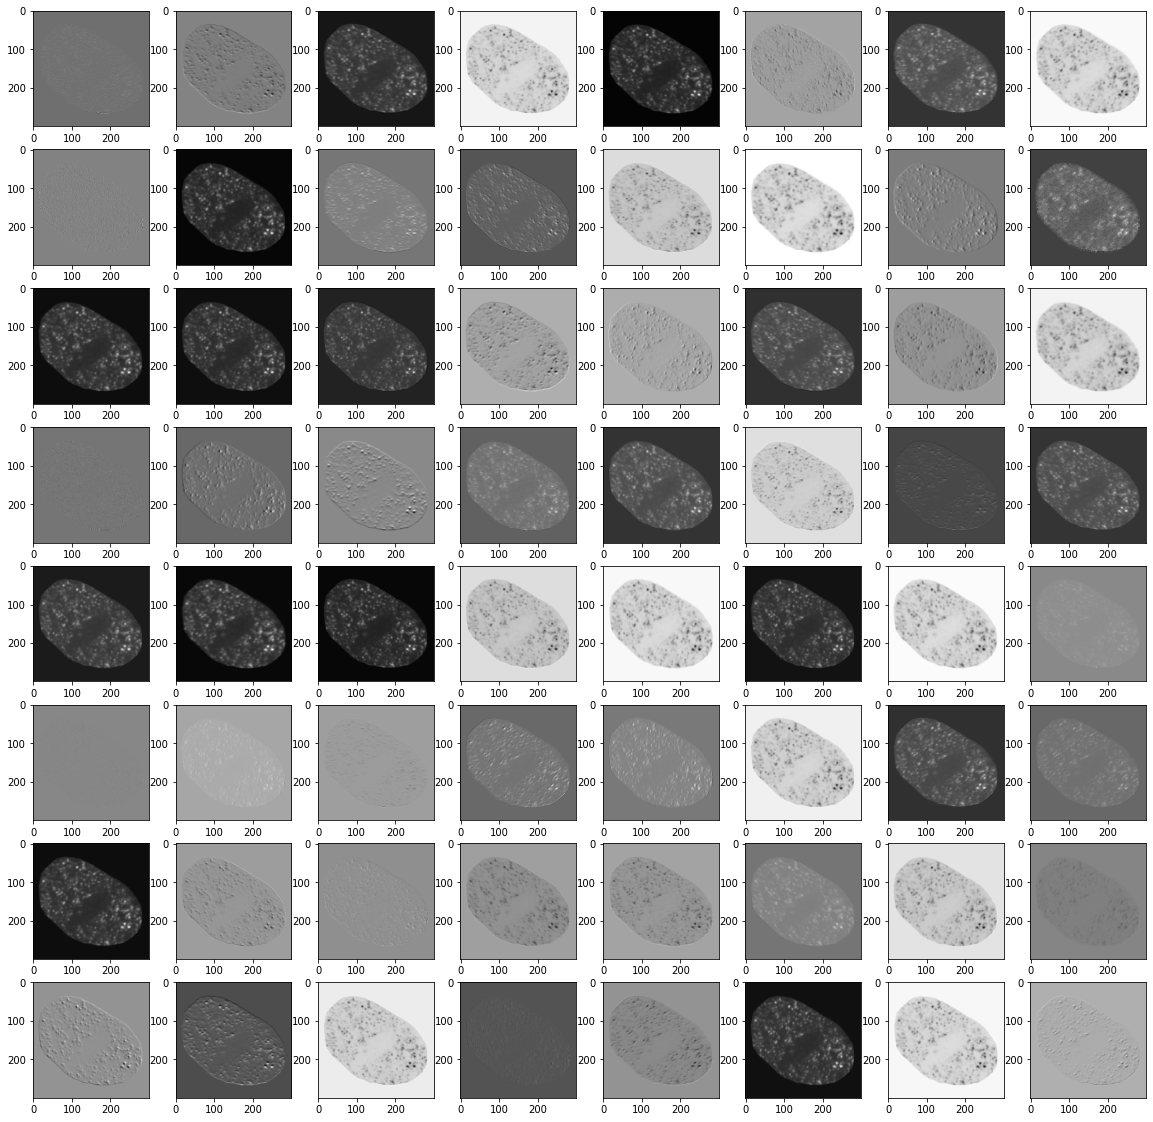

In [36]:
# plot each layer result
target_layer = "resnet.conv1"    
for key in [target_layer]:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)
#     s = int(img.shape[0]/bn.shape[2])
    n = math.ceil(math.sqrt(bn.shape[1]))
    plt.figure(figsize=(20,20))
    for i in range(bn.shape[1]):
        plt.subplot(n,n,i+1)
#                 plt.imshow(bn[0,i,:,:], cmap='gray')
        plt.imshow(bn[0,i], cmap='gray')
    plt.show()

resnet.maxpool  :  torch.Size([1, 64, 150, 150])


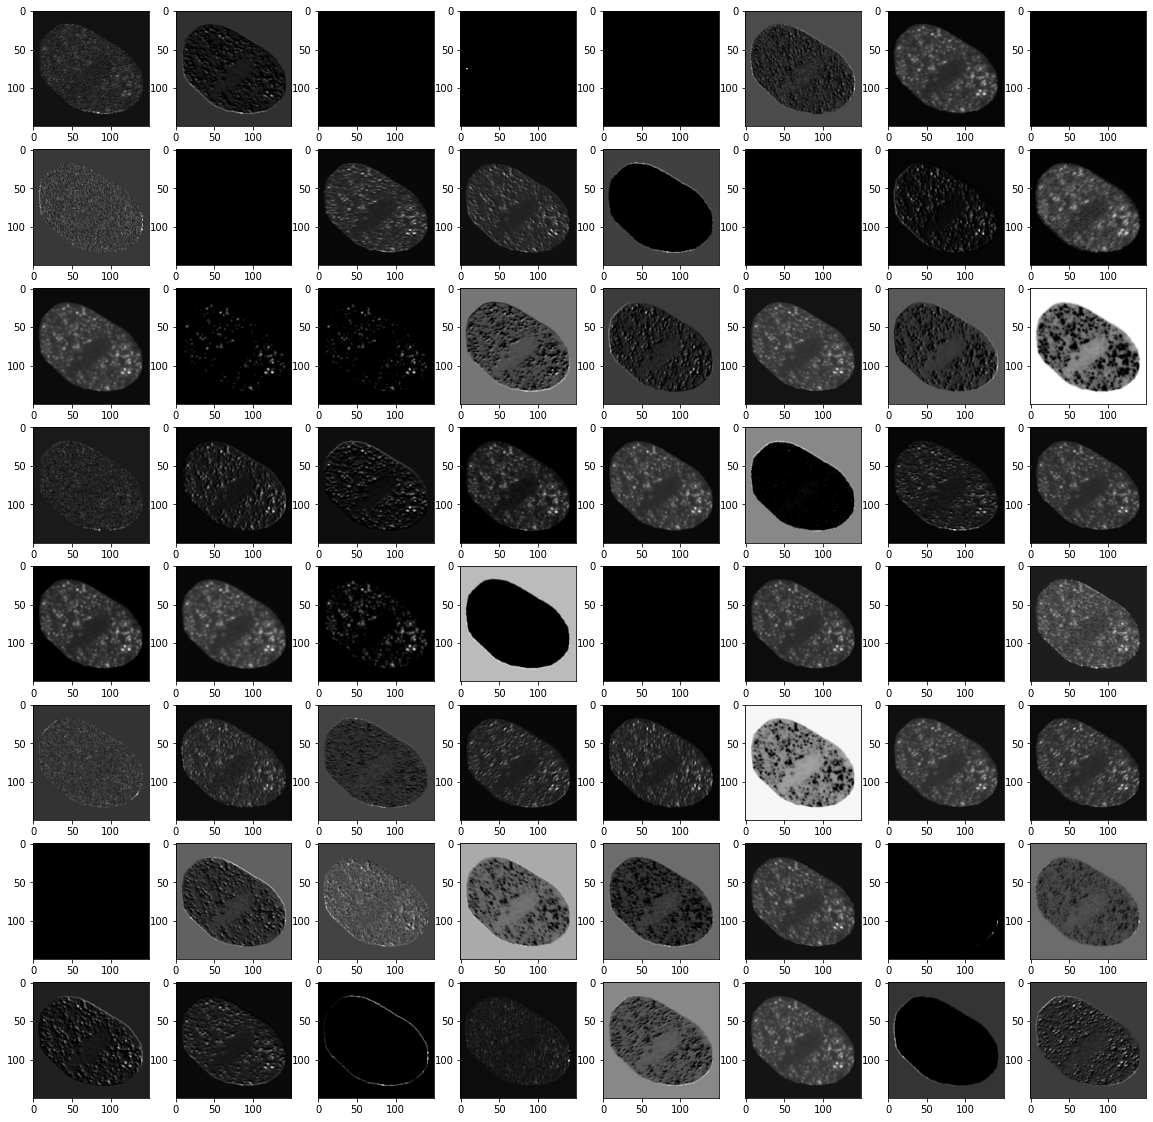

In [37]:
target_layer = "resnet.maxpool"    
for key in [target_layer]:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)
#     s = int(img.shape[0]/bn.shape[2])
    n = math.ceil(math.sqrt(bn.shape[1]))
    plt.figure(figsize=(20,20))
    for i in range(bn.shape[1]):
        plt.subplot(n,n,i+1)
#                 plt.imshow(bn[0,i,:,:], cmap='gray')
        plt.imshow(bn[0,i], cmap='gray')
    plt.show()

In [24]:
for key in feature_activation:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)

resnet.conv1  :  torch.Size([1, 64, 300, 300])
resnet.bn1  :  torch.Size([1, 64, 300, 300])
resnet.relu  :  torch.Size([1, 64, 300, 300])
resnet.maxpool  :  torch.Size([1, 64, 150, 150])
resnet.layer1.0.conv1  :  torch.Size([1, 64, 150, 150])
resnet.layer1.0.bn1  :  torch.Size([1, 64, 150, 150])
resnet.layer1.0.relu  :  torch.Size([1, 64, 150, 150])
resnet.layer1.0.conv2  :  torch.Size([1, 64, 150, 150])
resnet.layer1.0.bn2  :  torch.Size([1, 64, 150, 150])
resnet.layer1.0  :  torch.Size([1, 64, 150, 150])
resnet.layer1.1.conv1  :  torch.Size([1, 64, 150, 150])
resnet.layer1.1.bn1  :  torch.Size([1, 64, 150, 150])
resnet.layer1.1.relu  :  torch.Size([1, 64, 150, 150])
resnet.layer1.1.conv2  :  torch.Size([1, 64, 150, 150])
resnet.layer1.1.bn2  :  torch.Size([1, 64, 150, 150])
resnet.layer1.1  :  torch.Size([1, 64, 150, 150])
resnet.layer1  :  torch.Size([1, 64, 150, 150])
resnet.layer2.0.conv1  :  torch.Size([1, 128, 75, 75])
resnet.layer2.0.bn1  :  torch.Size([1, 128, 75, 75])
resnet.